In [3]:
import sqlite3
from Bio import SeqIO
import tqdm

# Name: UniRef90_A0A009GMH1
# Description: UniRef90_A0A009GMH1 Uncharacterized protein n=11 Tax=Acinetobacter TaxID=469 RepID=A0A009GMH1_9GAMM
# Seq('MNIWWNIDIKDGVVSHDSISWIDDNFEINEDTVFDLSEDLLQISFNNNKILDVG...NNI')

def fasta_to_db(input):
    con = sqlite3.connect('uniref90-10pm.db')
    cur = con.cursor()

    # Create table if it doesn't exist
    cur.execute('''
        CREATE TABLE IF NOT EXISTS uniref90 (
            name TEXT PRIMARY KEY,
            sequence TEXT,
            embedding BLOB
        )
    ''')

    # Read the FASTA file
    for record in tqdm.tqdm(SeqIO.parse(input, "fasta"), total=5358646):
        # Insert the record into the database
        cur.execute('''
            INSERT INTO uniref90 (name, sequence, embedding)
            VALUES (?, ?, ?)
        ''', (record.id[9:], str(record.seq), None))

    # Commit the changes and close the connection
    con.commit()
    con.close()


In [4]:
fasta_to_db('uniref_count_10_TO_AND_identity_0_9_2024_09_07.fasta')

100%|██████████| 5358646/5358646 [00:57<00:00, 93681.19it/s] 


In [26]:
from Bio import SeqIO
import tqdm

#get the shortest sequence in the fasta file
def get_shortest_seq(file):
    shortest_seq = ''
    shortest_length = 1000000
    for record in SeqIO.parse(file, 'fasta'):
        if len(record.seq) < shortest_length:
            shortest_seq = record.seq
            shortest_length = len(record.seq)
        if len(record.seq) == 11:
            return str(record.seq)
    return str(shortest_seq)

sequence = get_shortest_seq('uniref_count_10_TO_AND_identity_0_9_2024_09_07.fasta')

In [27]:
print(sequence)

sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", sequence)))]
print(sequence_examples)
print(len(sequence))

EKDESEPEIRM
['E K D E S E P E I R M']
11


In [28]:
ids = tokenizer(sequence_examples, add_special_tokens=True, padding="longest")
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

In [29]:
import time

start = time.time()

with torch.no_grad():
    embedding_repr = model(input_ids=input_ids, attention_mask=attention_mask)

end = time.time()

print("Time taken:", end-start)

Time taken: 9.711489915847778


In [30]:
emb_0 = embedding_repr.last_hidden_state[0,:7] # shape (7 x 1024)

# if you want to derive a single representation (per-protein embedding) for the whole protein
emb_0_per_protein = emb_0.mean(dim=0) # shape (1024)

In [ ]:
print(emb_0_per_protein)
print(emb_0_per_protein.shape)

In [3]:
# get a distribution of the lengths of the sequences in the fasta file and plot it
# store key-value pairs of the form {sequence: length}
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from Bio import SeqIO

lengths = {}
# for record in tqdm.tqdm(SeqIO.parse('uniref_count_10_TO_AND_identity_0_9_2024_09_07.fasta', 'fasta')):
#     lengths[record.id[9:]] = len(record.seq)

In [10]:
for record in tqdm.tqdm(SeqIO.parse('uniref_count_10_TO_AND_identity_0_9_2024_09_07.fasta', 'fasta'), desc='Reading sequences', unit='sequences', total=5358646):
    if record.features != []:
        print(record.features)
        break

Reading sequences: 100%|██████████| 5358646/5358646 [00:34<00:00, 157464.68sequences/s]


Number of sequences: 5358646
Shortest sequence: 11
Longest sequence: 37853
Mean sequence length: 421.10678107865306
Median sequence length: 331.0
Standard deviation of sequence lengths: 415.21017050828937


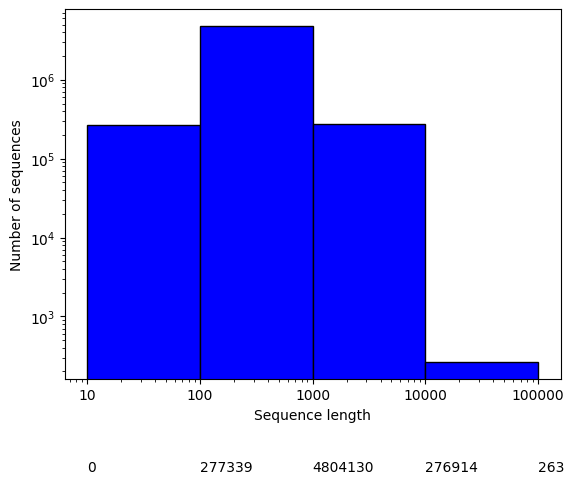

In [37]:
# also print statistics
print('Number of sequences:', len(lengths))
print('Shortest sequence:', min(lengths.values()))
print('Longest sequence:', max(lengths.values()))
print('Mean sequence length:', np.mean(list(lengths.values())))
print('Median sequence length:', np.median(list(lengths.values())))
print('Standard deviation of sequence lengths:', np.std(list(lengths.values())))

# plot it as sequence lengths 10, 100, 1000, 10000, 100000, 1000000
# show exact numbers of how many sequences are in each bin
# plot x-scale should start at 10
bins = [10, 100, 1000, 10000, 100000]
plt.hist(lengths.values(), bins, color='blue', edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sequence length')
plt.ylabel('Number of sequences')
plt.xticks(bins, bins)
currentbin = 0
for i in range(len(bins)):
    bincount = len([x for x in lengths.values() if x <= bins[i]])
    plt.text(bins[i], 10, bincount-currentbin, verticalalignment='bottom')
    currentbin = bincount
plt.show()



In [2]:
# get a good distributions of sequences in batches categorized by length to input into embedding generator, export to a file
# 1000 sequences per bin
import tqdm
import h5py
from Bio import SeqIO
# get the sequences and their ids in the fasta file
sequences = {}
for record in tqdm.tqdm(SeqIO.parse('uniref_count_10_TO_AND_identity_0_9_2024_09_07.fasta', 'fasta'), desc='Reading sequences', unit='sequences', total=5358646):
    sequences[record.id[9:]] = str(record.seq)
# sort the sequences by length
sequences = {k: v for k, v in sorted(sequences.items(), key=lambda item: len(item[1]))}

Reading sequences: 100%|██████████| 5358646/5358646 [00:41<00:00, 129577.21sequences/s]


In [4]:
print('Number of sequences:', len(sequences))
# print first 10
for i, (k, v) in enumerate(sequences.items()):
    print(k, v)
    if i == 9:
        break

Number of sequences: 5358646
A0A0A7EVS0 EKDESEPEIRM
A0A0C5CHF9 MIRKQGISGPL
A0A2Z1UDR3 RKQQAVYRIVA
A0A5K0XC37 MVNPGPLTPGQ
A0A5K0Z0F8 SEGSPSDAKNA
A0A5K1CDI2 CYIYLSEGLAM
A0A5K1CVY9 MATILDRENTT
A0A5K1D2F7 MAQASEPNLPE
A0A5K1D421 VVTEDMGVVKQ
A0A5K1GP01 AKAEKEDPRNH


In [5]:
print(max([len(x) for x in sequences.values()]))

37853


In [ ]:
# get sequences in batches of 1000
# save them to a file
# batches should contain sequences of lengths 10-100, 100-1000, 1000-10000, 10000-100000

batches = [[], [], [], []]

for id, seq in sequences.items():
    if 10 <= len(seq) <= 100 and len(batches[0]) < 1000:
        batches[0].append((id, seq))
        
    elif 100 < len(seq) <= 1000 and len(batches[1]) < 1000:
        batches[1].append((id, seq))
        
    elif 1000 < len(seq) <= 10000 and len(batches[2]) < 1000:
        batches[2].append((id, seq))
        
    elif 10000 < len(seq) <= 100000 and len(batches[3]) < 1000:
        batches[3].append((id, seq))
        

for batch in batches:
    print(len(batch))
    print(batch[:10])
    print(max([len(x[1]) for x in batch]))


In [22]:
# save the batches to their respective fasta files
for i, batch in enumerate(batches):
    with open(f'batch_{i}.fasta', 'w') as f:
        for id, seq in batch:
            f.write(f'>{id}\n{seq}\n')

In [24]:
# check if the files are saved correctly
for i in range(4):
    for record in SeqIO.parse(f'batch_{i}.fasta', 'fasta'):
        print(record)
        break

ID: A0A0A7EVS0
Name: A0A0A7EVS0
Description: A0A0A7EVS0
Number of features: 0
Seq('EKDESEPEIRM')
ID: A0A009HMQ2
Name: A0A009HMQ2
Description: A0A009HMQ2
Number of features: 0
Seq('MLEANKKLVYSGDEVLSVLQEIEFILISLHKIGSYYAETLPNSYEEYAKETTNF...ARK')
ID: A0A031IK42
Name: A0A031IK42
Description: A0A031IK42
Number of features: 0
Seq('MRPERLTLRAFGPFAGEETIDFTALAGRTMFVISGNTGAGKTTIFDALTFALYG...VVE')
ID: UPI002FE4D26F
Name: UPI002FE4D26F
Description: UPI002FE4D26F
Number of features: 0
Seq('MDYSSFTGAPRFLTRPKAFMMSVGKDASLSCQIIGNPIPMVTWEKDKLPIMSGG...PRQ')
